# RL an introduction by Sutton and Barto
## Chapter 6, TD prediction
* [solution](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction)
### Cliff walking problem
    * example 6.6, p.132

In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# hyperparameters for creating environment
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

In [4]:
# hyperparameters for agent

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

In [5]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (
        action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START

    return next_state, reward

In [6]:
# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.argmax(values_)
    # TODO
    # refactoring with np.argmax?


#### For Sarsa algorithm
* @q_value: values for state action pair, will be updated
* @expected: if True, will use expected Sarsa algorithm
* @step_size: step size for updating
* @return: total rewards within this episode

In [7]:
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

#### For Q-learning
* @q_value: values for state action pair, will be updated
* @step_size: step size for updating
* @return: total rewards within this episode

$ Q_{new}(s_{t},a_{t}) = Q(s_{t},a_{t}) + \alpha * (R_{t+1} + \gamma * max_{a \in A}Q(s_{t+1}, a) - Q(s_{t}, a_{t})) $

In [8]:
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0
    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards

In [9]:
# print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    for row in optimal_policy:
        print(row)

In [10]:
episodes = 500

# perform 500 independent runs
runs = 500

rewards_sarsa = np.zeros(episodes)
rewards_q_learning = np.zeros(episodes)

for r in tqdm(range(runs)):
    q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    q_q_learning = np.copy(q_sarsa)
    for i in range(0, episodes):
        # cut off the value by -100 to draw the figure more elegantly
        # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
        # rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
        rewards_sarsa[i] += sarsa(q_sarsa)
        rewards_q_learning[i] += q_learning(q_q_learning)
        
rewards_sarsa /= runs
rewards_q_learning /= runs

100%|██████████| 500/500 [01:21<00:00,  6.28it/s]


In [11]:
# display optimal policy
print('Sarsa Optimal Policy:')
print_optimal_policy(q_sarsa)
print('Q-Learning Optimal Policy:')
print_optimal_policy(q_q_learning)

Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'U', 'D', 'D']
['U', 'L', 'U', 'L', 'L', 'L', 'R', 'U', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'D', 'R', 'D']
['D', 'D', 'R', 'R', 'R', 'D', 'D', 'R', 'R', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


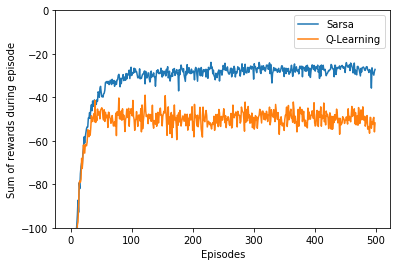

In [12]:
plt.plot(rewards_sarsa, label='Sarsa')
plt.plot(rewards_q_learning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()

In [13]:
step_sizes = np.arange(0.1, 1.1, 0.1)
episodes = 1000
runs = 10

ASY_SARSA = 0
ASY_EXPECTED_SARSA = 1
ASY_QLEARNING = 2
INT_SARSA = 3
INT_EXPECTED_SARSA = 4
INT_QLEARNING = 5
methods = range(0, 6)

performace = np.zeros((6, len(step_sizes)))

for run in range(runs):
    for ind, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_expected_sarsa = np.copy(q_sarsa)
        q_q_learning = np.copy(q_sarsa)
        for ep in range(episodes):
            sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
            expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
            q_learning_reward = q_learning(q_q_learning, step_size=step_size)
            performace[ASY_SARSA, ind] += sarsa_reward
            performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
            performace[ASY_QLEARNING, ind] += q_learning_reward

            if ep < 100:
                performace[INT_SARSA, ind] += sarsa_reward
                performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[INT_QLEARNING, ind] += q_learning_reward

performace[:3, :] /= episodes * runs
performace[3:, :] /= 100 * runs
labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
              'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


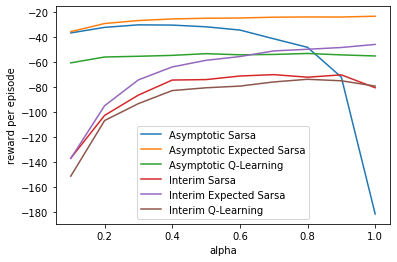

In [14]:
for method, label in zip(methods, labels):
    plt.plot(step_sizes, performace[method, :], label=label)
plt.xlabel('alpha')
plt.ylabel('reward per episode')
plt.legend()

### Maximization Bias

In [15]:
import copy

In [16]:
# environment
# state A
STATE_A = 0

# state B
STATE_B = 1

# use one terminal state
STATE_TERMINAL = 2

# starts from state A
STATE_START = STATE_A

# possible actions in A
ACTION_A_RIGHT = 0
ACTION_A_LEFT = 1

In [17]:
# hyperparameter for agent
# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.1

# discount for max value
GAMMA = 1.0

# possible actions in B, maybe 10 actions or more action possible
ACTIONS_B = range(0, 20)

# all possible actions
STATE_ACTIONS = [[ACTION_A_RIGHT, ACTION_A_LEFT], ACTIONS_B]

# state action pair values, if a state is a terminal state, then the value is always 0
INITIAL_Q = [np.zeros(2), np.zeros(len(ACTIONS_B)), np.zeros(1)]

# set up destination for each state and each action, matching with possible action
TRANSITION = [[STATE_TERMINAL, STATE_B], [STATE_TERMINAL] * len(ACTIONS_B)]

In [18]:
# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(STATE_ACTIONS[state])
    else:
        values_ = q_value[state]
        return np.argmax(values_)

In [19]:
# take @action in @state, return the reward
def take_action(state, action):
    if state == STATE_A:
        return 0
    return np.random.normal(-0.1, 1)

In [20]:
# if there are two state action pair value array, use double Q-Learning
# otherwise use normal Q-Learning
def q_learning(q1, q2=None):
    state = STATE_START
    # track the # of action left in state A
    left_count = 0
    while state != STATE_TERMINAL:
        if q2 is None:
            action = choose_action(state, q1)
        else:
            # derive a action form Q1 and Q2
            action = choose_action(state, [item1 + item2 for item1, item2 in zip(q1, q2)])
        if state == STATE_A and action == ACTION_A_LEFT:
            left_count += 1
        reward = take_action(state, action)
        next_state = TRANSITION[state][action]
        if q2 is None:
            active_q = q1
            target = np.max(active_q[next_state])
        else:
            if np.random.binomial(1, 0.5) == 1:
                active_q = q1
                target_q = q2
            else:
                active_q = q2
                target_q = q1
            # best_action = np.random.choice([action_ for action_, value_ in enumerate(active_q[next_state]) if value_ == np.max(active_q[next_state])])
            best_action = np.argmax(active_q[next_state])
            target = target_q[next_state][best_action]

        # Q-Learning update
        active_q[state][action] += ALPHA * (
            reward + GAMMA * target - active_q[state][action])
        state = next_state
    return left_count

100%|██████████| 1000/1000 [00:06<00:00, 148.31it/s]


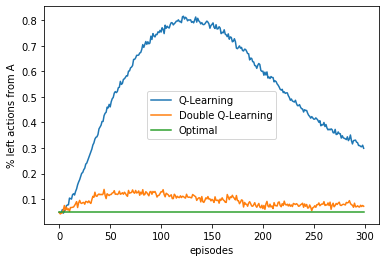

In [21]:
episodes = 300
runs = 1000
left_counts_q_ = np.zeros((runs, episodes))
left_counts_double_q_ = np.zeros((runs, episodes))

for run in tqdm(range(runs)):
    q = copy.deepcopy(INITIAL_Q)
    q1 = copy.deepcopy(INITIAL_Q)
    q2 = copy.deepcopy(INITIAL_Q)
    for ep in range(0, episodes):
        left_counts_q_[run, ep] = q_learning(q)
        left_counts_double_q_[run, ep] = q_learning(q1, q2)
left_counts_q = left_counts_q_.mean(axis=0)
left_counts_double_q = left_counts_double_q_.mean(axis=0)

plt.plot(left_counts_q, label='Q-Learning')
plt.plot(left_counts_double_q, label='Double Q-Learning')
plt.plot(np.ones(episodes) * 0.05, label='Optimal')
plt.xlabel('episodes')
plt.ylabel('% left actions from A')
plt.legend()

### Windy Gridworld

In [22]:
# world height
WORLD_HEIGHT = 7

# world width
WORLD_WIDTH = 10

# wind strength for each column
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probability for exploration
EPSILON = 0.1

# Sarsa step size
ALPHA = 0.5

# reward for each step
REWARD = -1.0

START = [3, 0]
GOAL = [3, 7]
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

In [23]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False

In [24]:
# play for an episode
def episode(q_value):
    # track the total time steps in this episode
    time = 0

    # initialize state
    state = START

    # choose an action based on epsilon-greedy algorithm
    if np.random.binomial(1, EPSILON) == 1:
        action = np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # keep going until get to the goal state
    while state != GOAL:
        next_state = step(state, action)
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[next_state[0], next_state[1], :]
            next_action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        # Sarsa update
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + q_value[next_state[0], next_state[1], next_action] -
                     q_value[state[0], state[1], action])
        state = next_state
        action = next_action
        time += 1
    return time

Text(0.5, 0, 'Episodes')

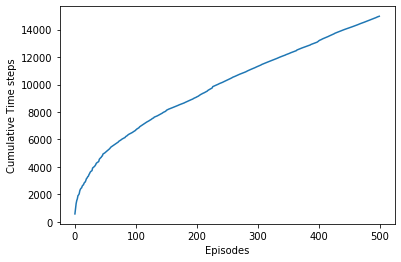

In [25]:
q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
episode_limit = 500

steps = []
ep = 0
while ep < episode_limit:
    steps.append(episode(q_value))
    # time = episode(q_value)
    # episodes.extend([ep] * time)
    ep += 1

steps_cum = np.add.accumulate(steps)

plt.plot(steps_cum)
plt.ylabel('Cumulative Time steps')
plt.xlabel('Episodes')


Text(0.5, 0, 'Episodes')

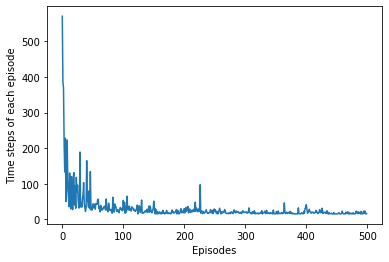

In [26]:
plt.plot(steps)
plt.ylabel('Time steps of each episode')
plt.xlabel('Episodes')

In [27]:
optimal_policy = []
for i in range(0, WORLD_HEIGHT):
    optimal_policy.append([])
    for j in range(0, WORLD_WIDTH):
        if [i, j] == GOAL:
            optimal_policy[-1].append('G')
            continue
        bestAction = np.argmax(q_value[i, j, :])
        if bestAction == ACTION_UP:
            optimal_policy[-1].append('U')
        elif bestAction == ACTION_DOWN:
            optimal_policy[-1].append('D')
        elif bestAction == ACTION_LEFT:
            optimal_policy[-1].append('L')
        elif bestAction == ACTION_RIGHT:
            optimal_policy[-1].append('R')
print('Optimal policy is:')
for row in optimal_policy:
    print(row)
print('Wind strength for each column:\n{}'.format([str(w) for w in WIND]))

Optimal policy is:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'L', 'R', 'R', 'D', 'R', 'R', 'R', 'U', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'L', 'D']
['R', 'R', 'D', 'U', 'R', 'R', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'L', 'L']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'L', 'L']
Wind strength for each column:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


### Random Walk

In [28]:
# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
# This trick has been used in Gambler's Problem
# VALUES[6] = 1

# set up true state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
# TRUE_VALUE[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

In [29]:
TRUE_VALUE

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 0.        ])

### For TD
* @values: current states value, will be updated if @batch is False
* @alpha: step size
* @batch: whether to update @values

In [30]:
def temporal_difference(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [state]
    rewards = []
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards except for rt terminal are 0
        reward = 0
        trajectory.append(state)
        if state == 6:
            reward = 1.0
            if not batch:
                values[old_state] += alpha * (reward + values[state] - values[old_state])
            break
        elif state == 0:
            if not batch:
                values[old_state] += alpha * (reward + values[state] - values[old_state])
            break
        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        # if state == 6 or state == 0:
        #    break
        rewards.append(reward)
    rewards.append(reward)
    return trajectory, rewards

In [31]:
test_values = np.zeros(7)
test_values[:] = 0.5
print(temporal_difference(test_values))
print(test_values)

([3, 4, 3, 2, 3, 4, 5, 4, 5, 4, 3, 4, 3, 4, 3, 2, 1, 2, 1, 2, 3, 4, 5, 4, 5, 6], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0])
[0.5 0.5 0.5 0.5 0.5 0.6 0.5]


### For MC
* @values: current states value, will be updated if @batch is False
* @alpha: step size
* @batch: whether to update @values

In [32]:
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [3]

    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break

    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])
    return trajectory, [returns] * (len(trajectory) - 1) # discount value = 1  

In [33]:
# Example 6.2 left
def compute_state_value():
    episodes = [0, 1, 10, 100]
    current_values = np.copy(VALUES)
    plt.figure(1)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plt.plot(current_values[1:6], label=str(i) + ' episodes')
        temporal_difference(current_values)
    plt.plot(TRUE_VALUE[1:6], label='true values')
    #plt.xlim(1,5)
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()

In [34]:
# Example 6.2 right
def rms_error():
    # Same alpha value can appear in both arrays
    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    episodes = 100 + 1
    runs = 100
    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(episodes)
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'
        for r in tqdm(range(runs)):
            errors = []
            current_values = np.copy(VALUES)
            for i in range(0, episodes):
                errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
                if method == 'TD':
                    temporal_difference(current_values, alpha=alpha)
                else:
                    monte_carlo(current_values, alpha=alpha)
            total_errors += np.asarray(errors)
        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', alpha = %.02f' % (alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

In [35]:
# Figure 6.2
# @method: 'TD' or 'MC'
def batch_updating(method, episodes, alpha=0.001):
    # perform 100 independent runs
    runs = 100
    total_errors = np.zeros(episodes)
    for r in tqdm(range(0, runs)):
        current_values = np.copy(VALUES)
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(episodes):
            if method == 'TD':
                trajectory_, rewards_ = temporal_difference(current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        total_errors += np.asarray(errors)
    total_errors /= runs
    return total_errors

100%|██████████| 100/100 [00:00<00:00, 477.89it/s]


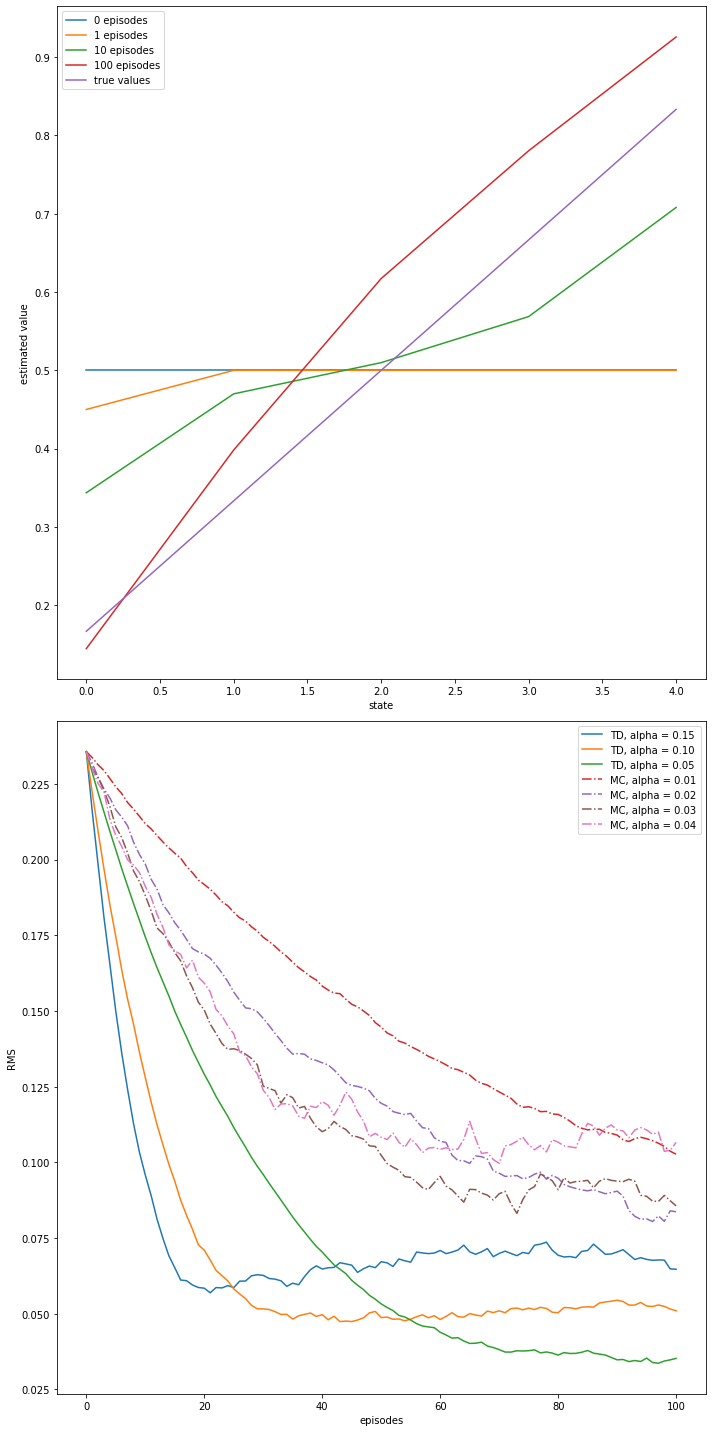

In [36]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
compute_state_value()

plt.subplot(2, 1, 2)
rms_error()
plt.tight_layout()

In [37]:
current_values = np.copy(VALUES)
for i in range(100):
    temporal_difference(current_values)
current_values

array([0.        , 0.12321123, 0.30887509, 0.42116525, 0.59650092,
       0.87244936, 0.        ])

100%|██████████| 100/100 [00:21<00:00,  4.54it/s]


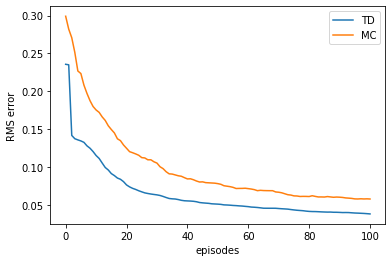

In [38]:
episodes = 100 + 1
td_erros = batch_updating('TD', episodes)
mc_erros = batch_updating('MC', episodes)

plt.plot(td_erros, label='TD')
plt.plot(mc_erros, label='MC')
plt.xlabel('episodes')
plt.ylabel('RMS error')
plt.legend()